## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [120]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from time import time
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import itertools
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [121]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [122]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train = True, 
                                                        transform = train_transform,
                                                        target_transform = None,
                                                        download = download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train = False, 
                                                       transform = test_transform,
                                                       target_transform = None,
                                                       download = download)
def test_train_split(dataset, split = 0.8):    
    """
    Looks similar to sklearn one.
    Params:
    --------------
    dataset -- torch.utils.data.Dataset to split
    split -- float, split (to train size)
    Returns:
    --------------
    train_set, valid_set -- splitted Datasets of size:
    (split * len(dataset), len(dataset) - len(train_set))
    """
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset




In [160]:
train_set, valid_set = test_train_split(fmnist_dataset_train)
train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)


In [124]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [125]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes))
        
    def forward(self, x):       
        return self.model(x)
    

In [126]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 512]         401,920
       BatchNorm1d-4                  [-1, 512]           1,024
           Dropout-5                  [-1, 512]               0
              ReLU-6                  [-1, 512]               0
       BatchNorm1d-7                  [-1, 512]           1,024
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 10]           5,130
Total params: 410,666
Trainable params: 410,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 1.57
Estimated Total Size (MB): 1.61
-------------------------------------------

Your experiments come here:

In [127]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

def train_model(model, train_set, valid_set, 
                loss_fn, opt, 
                n_epochs: int, 
                device = device,
                return_train_metrics = False):
    
    train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)
    valid_loader = DataLoader(valid_set, batch_size = 128,
                                           shuffle = False,
                                           num_workers = 2)
    
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_train_accuracy = []
        
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            
            with torch.no_grad():
                _ = model.eval()
                y_pred = predictions.max(1)[1] 
                ep_train_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float)) / len(y_batch.cpu()))
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1] 
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        train_accuracy.append(np.mean(ep_train_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
        print(f"\t  training accuracy: {train_accuracy[-1]:.3f}")
    return train_loss, train_accuracy, val_loss, val_accuracy 

def evaluate_model(model, test_set, loss_fn, opt):
    test_loader = DataLoader(test_set, batch_size = 128,
                                          shuffle = False,
                                          num_workers = 2)
    _ = model.eval()
    print("\n\n TESTING MODEL...")
    losses = []
    metrics = []
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            y_pred = predictions.max(1)[1]
            losses.append(loss.item())
            metrics.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))
            
    print(f"\t test loss: {np.mean(losses):.6f}")
    print(f"\t test accuracy: {np.mean(metrics):.3f}")

    return np.mean(losses), np.mean(metrics)

Epoch 1 of 10 took 5.703s
	  training loss: 0.557496
	validation loss: 0.416687
	validation accuracy: 0.854
	  training accuracy: 0.807
Epoch 2 of 10 took 5.567s
	  training loss: 0.391739
	validation loss: 0.367608
	validation accuracy: 0.866
	  training accuracy: 0.860
Epoch 3 of 10 took 5.727s
	  training loss: 0.345285
	validation loss: 0.347477
	validation accuracy: 0.874
	  training accuracy: 0.875
Epoch 4 of 10 took 6.088s
	  training loss: 0.314202
	validation loss: 0.314458
	validation accuracy: 0.885
	  training accuracy: 0.887
Epoch 5 of 10 took 5.763s
	  training loss: 0.295555
	validation loss: 0.304889
	validation accuracy: 0.891
	  training accuracy: 0.892
Epoch 6 of 10 took 5.677s
	  training loss: 0.274352
	validation loss: 0.285040
	validation accuracy: 0.893
	  training accuracy: 0.899
Epoch 7 of 10 took 5.922s
	  training loss: 0.258553
	validation loss: 0.284879
	validation accuracy: 0.894
	  training accuracy: 0.906
Epoch 8 of 10 took 5.544s
	  training loss: 0.24

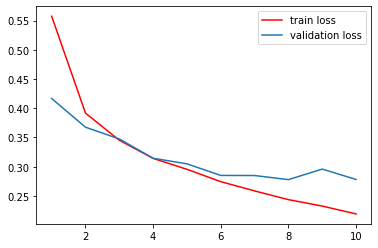

In [214]:
# Your experiments, training and validation loops here
#unlucky number :)
n_epochs = 10
train_set, valid_set = test_train_split(fmnist_dataset_train)
train_loss, _, val_loss, val_accuracy = train_model(model, train_set, valid_set,
                                                loss_func, opt, n_epochs)
_ = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
plt.plot(np.arange(1, n_epochs + 1, 1), train_loss, color = 'r', label = 'train loss')
plt.plot(np.arange(1, n_epochs + 1, 1), val_loss, label = 'validation loss')
plt.legend(loc = 'best')

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [128]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_dim = 28 * 28, num_classes = 10, input_channels = 1, hidden_dim = 16):
        super(self.__class__, self).__init__()
        hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(nn.Flatten())
        self.model.add_module('starter', 
                               torch.nn.Linear(input_dim, 2 * hidden_dim)) 
        self.model.add_module(' ', nn.ReLU())
        self.model.add_module('1st', 
                               torch.nn.Linear(2 * hidden_dim, hidden_dim)) 
        self.model.add_module(' _', nn.ReLU())
        self.model.add_module('classifier', 
                               torch.nn.Linear(hidden_dim, num_classes)) 
        
    def forward(self, x):       
        return self.model(x)

In [129]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 32]          25,120
              ReLU-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
              ReLU-5                   [-1, 16]               0
            Linear-6                   [-1, 10]             170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.10
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [169]:
loss_func = nn.CrossEntropyLoss()
# train_set, _ = test_train_split(train_set,  .75)
def get_overfitting(n_epochs: int):  

    model = OverfittingNeuralNetwork(hidden_dim = 128).to(device)
    opt = torch.optim.Adam(model.parameters())
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, train_set, 
                                                valid_set,
                                                loss_func, opt, n_epochs)

    test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
    return 1. - np.array(train_accuracy), 1. - np.array(val_accuracy)
train_error, test_error = get_overfitting(20)

Epoch 1 of 20 took 4.223s
	  training loss: 0.642676
	validation loss: 0.487693
	validation accuracy: 0.821
	  training accuracy: 0.775
Epoch 2 of 20 took 4.209s
	  training loss: 0.429529
	validation loss: 0.433562
	validation accuracy: 0.840
	  training accuracy: 0.846
Epoch 3 of 20 took 4.230s
	  training loss: 0.377695
	validation loss: 0.397727
	validation accuracy: 0.859
	  training accuracy: 0.864
Epoch 4 of 20 took 4.453s
	  training loss: 0.349055
	validation loss: 0.365574
	validation accuracy: 0.867
	  training accuracy: 0.873
Epoch 5 of 20 took 4.189s
	  training loss: 0.322681
	validation loss: 0.354405
	validation accuracy: 0.872
	  training accuracy: 0.882
Epoch 6 of 20 took 4.280s
	  training loss: 0.307899
	validation loss: 0.346862
	validation accuracy: 0.874
	  training accuracy: 0.887
Epoch 7 of 20 took 4.352s
	  training loss: 0.290110
	validation loss: 0.352169
	validation accuracy: 0.876
	  training accuracy: 0.895
Epoch 8 of 20 took 4.233s
	  training loss: 0.28

Here we can see sign of overfitting. Error gap between train error and validation error is huge. 

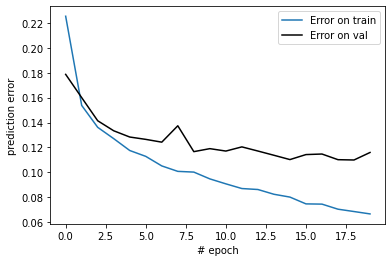

In [170]:
plt.plot(train_error, label = "Error on train")
plt.plot(test_error, label = "Error on val", color = 'k')
plt.xlabel("# epoch"); plt.ylabel("prediction error")
plt.legend(loc = "best")

plt.show()


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [171]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_dim = 28 * 28, num_classes = 10, input_channels = 1, hidden_dim = 16):
        super(self.__class__, self).__init__()
        hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(nn.Flatten())
        
        self.model.add_module('st bn', 
                               torch.nn.BatchNorm1d(input_dim))
        self.model.add_module('st', 
                               torch.nn.Linear(input_dim, 2 * hidden_dim)) 
        self.model.add_module('  _', nn.Dropout(.5))
        self.model.add_module('_ ', nn.ReLU())

        self.model.add_module('1st bn', 
                               torch.nn.BatchNorm1d(2 * hidden_dim))
        self.model.add_module('1st', 
                               torch.nn.Linear(2 * hidden_dim, hidden_dim)) 
        self.model.add_module('  __', nn.Dropout(.5))
        self.model.add_module('__ ', nn.ReLU())


        self.model.add_module('4th bn', 
                               torch.nn.BatchNorm1d(hidden_dim))
        self.model.add_module('  ___', nn.Dropout(.5))

        self.model.add_module('classifier', 
                               torch.nn.Linear(hidden_dim, num_classes)) 
    def forward(self, x):       
        out = self.model(x)
        return out
                            

In [164]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                   [-1, 32]          25,120
           Dropout-4                   [-1, 32]               0
              ReLU-5                   [-1, 32]               0
       BatchNorm1d-6                   [-1, 32]              64
            Linear-7                   [-1, 16]             528
           Dropout-8                   [-1, 16]               0
              ReLU-9                   [-1, 16]               0
      BatchNorm1d-10                   [-1, 16]              32
          Dropout-11                   [-1, 16]               0
           Linear-12                   [-1, 10]             170
Total params: 27,482
Trainable params: 27,482
Non-trainable params: 0
---------------------------------

In [174]:
loss_func = nn.CrossEntropyLoss()
def get_overfitting(n_epochs: int):  

    model = FixedNeuralNetwork(hidden_dim = 128).to(device)
    opt = torch.optim.Adam(model.parameters(), weight_decay = 1e-4)
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, train_set, 
                                                valid_set,
                                                loss_func, opt, n_epochs)

    test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
    return 1. - np.array(train_accuracy), 1. - np.array(val_accuracy)
train_error, test_error = get_overfitting(20)
# Your experiments, come here

Epoch 1 of 20 took 4.597s
	  training loss: 0.677862
	validation loss: 0.484349
	validation accuracy: 0.830
	  training accuracy: 0.763
Epoch 2 of 20 took 4.579s
	  training loss: 0.419950
	validation loss: 0.413038
	validation accuracy: 0.850
	  training accuracy: 0.850
Epoch 3 of 20 took 4.601s
	  training loss: 0.371923
	validation loss: 0.375817
	validation accuracy: 0.863
	  training accuracy: 0.865
Epoch 4 of 20 took 4.600s
	  training loss: 0.341246
	validation loss: 0.349149
	validation accuracy: 0.875
	  training accuracy: 0.876
Epoch 5 of 20 took 4.585s
	  training loss: 0.317175
	validation loss: 0.335565
	validation accuracy: 0.879
	  training accuracy: 0.886
Epoch 6 of 20 took 4.541s
	  training loss: 0.301993
	validation loss: 0.331725
	validation accuracy: 0.878
	  training accuracy: 0.891
Epoch 7 of 20 took 4.589s
	  training loss: 0.287390
	validation loss: 0.329776
	validation accuracy: 0.879
	  training accuracy: 0.895
Epoch 8 of 20 took 4.578s
	  training loss: 0.27

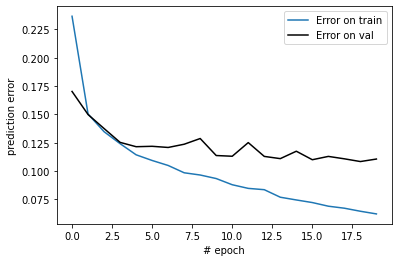

In [175]:
plt.plot(train_error, label = "Error on train")
plt.plot(test_error, label = "Error on val", color = 'k')
plt.xlabel("# epoch"); plt.ylabel("prediction error")
plt.legend(loc = "best")

plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._


_One of the most explicit signs of overfitting_ is that behaviour of a model's loss during training and validation is different: e.g. while loss on train in decreasing, loss on val is rising or not changing at all. That means that the model "knows" training set too well, however, its generalizing ability not too high for val set.

To avoid this we apply _regularization technics_ such as `dropout` and `batch_normaliztion` to the model. We could use weight decay that works like `l2-reg` but this is related to optimizer not to our model.

I tried to plot error of prediction (1. - accuracy_score) w.r.t. complexity of the model $-$ number of training epochs in this case. Unfortunately, i could not achieve meaningful gap but we can see that accuracy on test increased dramatically (~10%)

So, this method can help us avoid oferfitting for a long time $-$ `dropout` and `batch_normaliztion` do not allow the model to memorize train set too fast and increase its ability to generalize given test set.

To sum up, i think it is really useful to use `dropout` (selecting the rate is mnemonic rule that depends what rate of reg u want to have) and `batch_normaliztion` because scaling features sometimes decreases internal covariance shift and makes the loss smoother.